In [1]:
%%script false --no-raise-error
# run this to install things that aren't on colab by default! (comment out the %% line above)
!pip install preprocessor
!pip install auto-sklearn==0.14.3

In [44]:
import autosklearn.classification
import autosklearn.metrics
import pandas as pd
import numpy as np
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import preprocessor as p

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt

data loading functions

In [5]:
basepath = "/content/drive/MyDrive/DataScienceMaster/Experiment Design/"

# set this true if you want to actually run the AutoML section!
run = False

In [17]:
twitter_dict = {'racism':1,'sexism':2,'none':0}
def load_data(filename):
    data = pickle.load(open(filename, 'rb'))
    x_text = []
    labels = []
    for i in range(len(data)):
        if(HASH_REMOVE):
            x_text.append(p.tokenize((data[i]['text']).encode('utf-8')))
        else:
            x_text.append(data[i]['text'])
        label = data[i]['label']
        if N_CLASS == 3:
          label = twitter_dict[label]
        labels.append(label)
    return x_text,labels

def get_filename(dataset):
    global N_CLASS, HASH_REMOVE
    if(dataset=="twitter"):
        filename = basepath+"twitter_data.pkl"
        N_CLASS = 3
        HASH_REMOVE = False
    elif(dataset=="formspring"):
        N_CLASS = 2
        filename = basepath+"formspring_data.pkl"
        HASH_REMOVE = False
    elif(dataset=="wiki"):
        N_CLASS = 2
        filename = basepath+"wiki_data.pkl"
        HASH_REMOVE = False
    return filename


In [15]:
def get_train_test_data(data, labels, datarep="char", split=True):
  if datarep == "char":
    print("Using char n-grams based features")
    bow_transformer = CountVectorizer(max_features = 10000, ngram_range = (1,2)).fit(data)
    comments_bow = bow_transformer.transform(data)
    tfidf_transformer = TfidfTransformer(norm = 'l2').fit(comments_bow)
    comments_tfidf = tfidf_transformer.transform(comments_bow)
    features = comments_tfidf
  elif datarep == "word":
    print("Using word based features")
    bow_transformer = CountVectorizer(analyzer="word",max_features = 10000,stop_words='english').fit(data)
    comments_bow = bow_transformer.transform(data)
    tfidf_transformer = TfidfTransformer(norm = 'l2').fit(comments_bow)
    comments_tfidf = tfidf_transformer.transform(comments_bow)
    features = comments_tfidf
  else:
    print("invalid data represenation! Must be either 'char' or 'word'.")
    raise ValueError

  if split:
    split = min(split, 1-split)
    assert split < 1
    assert split > 0
    train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=split, random_state=31415, shuffle=True)
    return train_x, train_y, test_x, test_y
  else:
    return features, labels

def eval_model(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_test = np.array([int(x) for x in y_test])
  y_pred = np.array([int(x) for x in y_pred])
  return np.array([f1_score(y_test, y_pred, average=None)[1:]])


In [ ]:
# do auto-ml!

def get_model(train_x, train_y, time_limit=20*60): 
  automl = autosklearn.classification.AutoSklearnClassifier(
      time_left_for_this_task = time_limit,
      per_run_time_limit = time_limit//4,
      memory_limit = 6000,
      metric=autosklearn.metrics.f1_macro,
      exclude = {'classifier':["mlp"]},
      ensemble_size = 1,
      n_jobs = -1      
  )
  automl.fit(train_x, train_y)
  return automl

In [ ]:
results_char = {}

In [ ]:

data, labels = load_data(get_filename("wiki"))
x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep="char")
print(np.shape(x_train), np.shape(y_train))

Using char n-grams based features
(92691, 10000) (92691,)


In [ ]:
data, labels = load_data(get_filename("twitter"))
x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep="char")
print(np.shape(x_train), np.shape(y_train))

Using char n-grams based features
(12872, 10000) (12872,)


In [ ]:
data, labels = load_data(get_filename("formspring"))
x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep="char")
print(np.shape(x_train), np.shape(y_train))

Using char n-grams based features
(10218, 10000) (10218,)


In [ ]:
if run:
  for dataset in ["formspring", "twitter", "wiki"]:
    data, labels = load_data(get_filename(dataset))
    print("got {} data".format(dataset))
    x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep="char")
    model = get_model(x_train, y_train)
    results = eval_model(model, x_test, y_test)
    results_char[dataset] = {"scores":results, "model":model}


In [6]:
if run:
  with open(basepath+"results_tradml_charrepr.pkl", "wb") as f:
    pickle.dump(results_char, f, pickle.HIGHEST_PROTOCOL)
else:
  results_char = pickle.load(open(basepath+"results_tradml_charrepr.pkl", "rb"))

In [7]:
results_word = {}

In [8]:
if run:
  for dataset in ["formspring", "twitter", "wiki"]:
    data, labels = load_data(get_filename(dataset))
    print("got {} data".format(dataset))
    x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep="word")
    model = get_model(x_train, y_train)
    results = eval_model(model, x_test, y_test)
    results_word[dataset] = {"scores":results, "model":model}

In [11]:
if run:
  with open(basepath+"results_tradml_wordrepr.pkl","wb") as f:
    pickle.dump(results_word, f, pickle.HIGHEST_PROTOCOL)
else:
  results_word = pickle.load(open(basepath+"results_tradml_wordrepr.pkl", "rb"))

In [9]:
results_char

{'formspring': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.48201439],
         [0.41104294],
         [0.44370861]])},
 'twitter': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.68287037, 0.7210084 ],
         [0.78042328, 0.69529984],
         [0.72839506, 0.70792079]])},
 'wiki': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.5620438 ],
         [0.80297952],
         [0.

In [12]:
results_word

{'formspring': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.35950413],
         [0.53374233],
         [0.42962963]])},
 'twitter': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.72922252, 0.81150794],
         [0.71957672, 0.66288493],
         [0.72436751, 0.72970562]])},
 'wiki': {'model': AutoSklearnClassifier(ensemble_size=1, exclude={'classifier': ['mlp']},
                        memory_limit=6000, metric=f1_macro, n_jobs=-1,
                        per_run_time_limit=300, time_left_for_this_task=1200),
  'scores': array([[0.54405941],
         [0.81862197],
         [0.

In [ ]:
for ds in results_char:
  print("char representation")
  f1 = results_char[ds]["scores"][-1]
  print(ds, f1)
print()
for ds in results_word:
  print("word representation")
  f1 = results_word[ds]["scores"][-1]
  print(ds, f1)

char representation
formspring [0.44370861]
char representation
twitter [0.72839506 0.70792079]
char representation
wiki [0.66124827]

word representation
formspring [0.42962963]
word representation
twitter [0.72436751 0.72970562]
word representation
wiki [0.6536803]


In [ ]:
def cv_model(X, y, model):
  X,y = shuffle(X, y, random_state=42)
  kf = KFold(n_splits=10)
  scores = []
  for train_index, test_index in kf.split(X):
    y = np.asarray(y)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.refit(X_train,y_train)
    y_pred = model.predict(X_test)
    curr_scores = eval_model(model, X_test, y_test)
    scores.append(np.hstack(curr_scores))
  return scores

In [ ]:
scoredict = {}

for n,resultsdict in enumerate([results_char, results_word]):
  repr = "none"
  if n == 0:
    repr = "char"
  else:
    repr = "word"
  scoredict[repr] = {}
  for ds in resultsdict:
    orig_f1 = resultsdict[ds]["scores"][-1]
    model = resultsdict[ds]["model"]
    modeltype = model.leaderboard()["type"].values[0]
    print("training {} model on {} data, original test set score: {}".format(modeltype, ds, [round(x, 3) for x in orig_f1]))

    data, labels = load_data(get_filename(ds))
    features, labels = get_train_test_data(data, labels, datarep=repr, split=False)
    scores = cv_model(features, labels, model)
    avgscore = np.mean(scores, axis=0)
    print("Average CV score: ",np.round(avgscore,3))
    if ds != "twitter":
      scoredict[repr][ds] = {"model":modeltype, "cv_f1score":avgscore}
    else:
      scoredict[repr][ds] = {"model":modeltype, "cv_f1score_class1":avgscore[0], "cv_f1score_class2":avgscore[1]}
  print()

training extra_trees model on formspring data, original test set score: [0.444]
Using char n-grams based features
Average CV score:  [0.488]
training sgd model on twitter data, original test set score: [0.728, 0.708]
Using char n-grams based features
Average CV score:  [0.731 0.724]
training sgd model on wiki data, original test set score: [0.661]
Using char n-grams based features
Average CV score:  [0.662]

training extra_trees model on formspring data, original test set score: [0.43]
Using word based features
Average CV score:  [0.454]
training random_forest model on twitter data, original test set score: [0.724, 0.73]
Using word based features
Average CV score:  [0.756 0.739]
training sgd model on wiki data, original test set score: [0.654]
Using word based features
Average CV score:  [0.654]



In [ ]:
pickle.dump(scoredict, open(basepath+"cv_results.pkl", "wb"))

In [42]:
def indiv_eval(model, X_test, y_test, target_names=['Normal', 'Cyberbullying']):
    preds = model.predict(X_test)
    preds = list(preds)
    print(classification_report(y_test, preds))

    plt.figure()
    sns.heatmap(confusion_matrix(y_test, preds, normalize='true'), fmt='.2%', annot=True ,linewidths=.5,cmap='YlOrRd', annot_kws={"fontsize":10}, yticklabels=target_names, xticklabels=target_names)
    plt.xticks(rotation=45, ha='right')

    plt.show()

    return preds


char for formspring dataset

Using char n-grams based features
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2392
           1       0.48      0.41      0.44       163

    accuracy                           0.93      2555
   macro avg       0.72      0.69      0.70      2555
weighted avg       0.93      0.93      0.93      2555



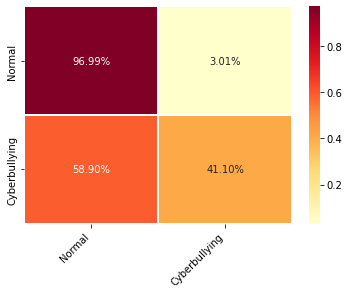


char for twitter dataset

Using char n-grams based features
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      2223
           1       0.68      0.78      0.73       378
           2       0.72      0.70      0.71       617

    accuracy                           0.83      3218
   macro avg       0.76      0.78      0.77      3218
weighted avg       0.83      0.83      0.83      3218



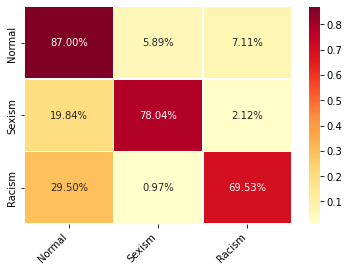


char for wiki dataset

Using char n-grams based features
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     20488
           1       0.56      0.80      0.66      2685

    accuracy                           0.90     23173
   macro avg       0.77      0.86      0.80     23173
weighted avg       0.93      0.90      0.91     23173



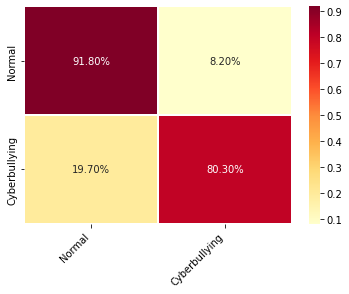


word for formspring dataset

Using word based features
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2392
           1       0.36      0.53      0.43       163

    accuracy                           0.91      2555
   macro avg       0.66      0.73      0.69      2555
weighted avg       0.93      0.91      0.92      2555



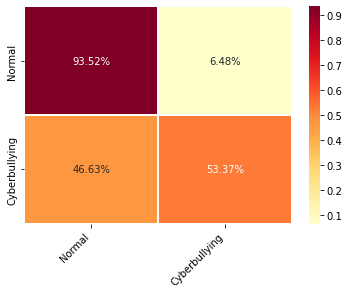


word for twitter dataset

Using word based features
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2223
           1       0.73      0.72      0.72       378
           2       0.81      0.66      0.73       617

    accuracy                           0.84      3218
   macro avg       0.80      0.77      0.78      3218
weighted avg       0.84      0.84      0.84      3218



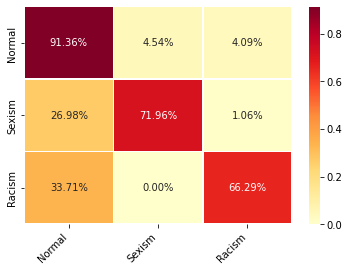


word for wiki dataset

Using word based features
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     20488
           1       0.54      0.82      0.65      2685

    accuracy                           0.90     23173
   macro avg       0.76      0.86      0.80     23173
weighted avg       0.92      0.90      0.91     23173



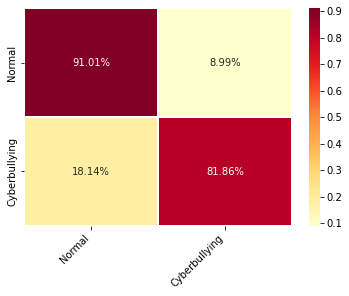

In [49]:
resultdict = {}
for repr in ["char", "word"]:
  for ds in ["formspring", "twitter", "wiki"]:
    print("\n{} for {} dataset\n".format(repr, ds))
    data, labels = load_data(get_filename(ds))
    x_train, y_train, x_test, y_test = get_train_test_data(data, labels, datarep=repr, split=0.2)
    if repr == "char":
      model = results_char[ds]["model"]
    else:
      model = results_word[ds]["model"]
    if ds == "twitter":
      labels = ["Normal", "Sexism", "Racism"]
    else:
      labels = ["Normal", "Cyberbullying"]
    results = indiv_eval(model, x_test, y_test, labels)
    resultdict[(ds, repr)] = results

In [51]:
pickle.dump(resultdict, open(basepath+"predictions_per_model.pkl", "wb"))